# Tutorial: Collecting messages from Telegram

## Set up 

[Telegram](https://telegram.org/) is a popular messaging application. This tutorial shows how to collect messages from any public channel/group chat on the platform using the [Telethon library](https://docs.telethon.dev/en/stable/) in Python. But first, you will need a Telegram account linked to your mobile number. 

### Start by:
1. Downloading the app
2. [Register](https://my.telegram.org/auth) your application and get your API id and API hash. 
3. Store the credentials (id/hash) safely. You can store them in a .env file:

```

TELEGRAM_API_ID = "987298"
TELEGRAM_API_HASH = "o898dnjdu23801kmcloewij"
PHONE_NUM = "+19810023456"

```
4. Install the Telethon library.  This is an asyncio Python 3 library used to interact with Telegram's API. You can find some examples of using asyncio [here](https://docs.telethon.dev/en/stable/concepts/asyncio.html).
```
python3 -m pip install --upgrade pip
python3 -m pip install --upgrade telethon
```

5. You will have to update both IPython to 7.0+ and ipykernel to version 5.0+ for async to be available. (More details about using async in notebooks can be found [here](https://blog.jupyter.org/ipython-7-0-async-repl-a35ce050f7f7)). Note that Asyncio code can create some issues when using it in Jupyter Notebooks. There are some differences in the syntax that is written jupyter v/s a .py script. Also, according to Telethon's documentation: "When using Telethon with such interpreters, you are also more likely to get “sqlite3.OperationalError: database is locked” with them. If they cause too much trouble, just write your code in a .py file and run that, or use the normal python interpreter."

```
pip install IPython ipykernel --update

```

6. Install the asyncio library. This library allows you to do concurrent asynchronous programming in Python.

```
python3 -m pip install asyncio
```




## Lets get started!

In [12]:
from telethon import TelegramClient
import pandas as pd
import json 
from pathlib import Path
import json
import os

from config import Config # import the api id, hash from here 


In [13]:
# You can test the code by inputing your cridentials and uncommenting
# Ideally dont hardcode it here
# api_id = Config.api_id
# api_hash = Config.api_hash


## Some notes on concurrent programming & asyncio: 

### What does asyncronous mean?
The usual program in Python excutes code sequentially/synchronously --i.e.-- tasks/unit of work must complete before moving forward in the program. For example, a function must execute and provide a result before you can move on to your next task in the program. 

This is not required in asyncronous programming. Asynchronous programming is a type of parallel programming where you do not need to wait for a unit of work to complete before proceeding. For example, you can submit a HTTP request and while waiting for the HTTP request to finish/return a response, you can do other work that’s waiting in a queue. 

*Note:* This is not multithreading. Instead, we have have a single thread and we are switching between tasks to utilize time more efficiently and not waste time waiting for tasks to complete  before proceeding. 

### Buikding blocks to do this:
### Coroutines?
This is a fuction which can pause and resume its execution at any stage.
To make such functions:
1. Simply put the *async* keyword at the beginning of your function 
```
async def my_coroutine():
    do something
    return
```
2. When you call such a function/coroutine, it will return a *coroutine object*. Unlike a normal function, this function has not been "executed".... yet.
3. These coroutine objects *will* be executed using other means (an *event loop*, explained below).

### Await keyword?
This keyword is used to pause the execution of a coroutine. We simply add the keyword *await*  in front of the object you want to await. When the function encounters *await* --> function will stop there --> *awaitable object* will start running --> once the *awaitable object* completes --> then the remaining coroutine will proceed. 

```
async def my_coroutine():
    do something
    await something # wait for this task to complete
    do something else # proceed with the function
    return
```

When there are more than one coroutines, awaitable objects provide *context switching* ability or an "exit gate" through which we can switch between multiple coroutines. It allows you to run another coroutine during the period of delay created by await.

Awaitable objects can be coroutines, Tasks, Futures. *Tasks* allow you to schedule coroutines. You can convert a coroutine into a task (asyncio.create_task()) and schedule it to run concurrently. *Futures* allows represents a future result of an asynchronous operation.  

### Executing coroutines
We need an *event loop* which executes all the tasks which are passed to it. Generally runs in the main thread.

```
asyncio.run(my_coroutine())
```
Interpreters like Jupyter run the asyncio event loop implicitly, which is why we dont create it it below. All async functions must be scheduled for execution on the event loop instead of attempting to create a new loop in the same thread. Again, the way Jupyter runs creates slight differences in the way code is written in a script (.py files).



In [14]:
# Get API credentials from the Config.py file 
api_id = Config.api_id
api_hash = Config.api_hash

# This is the name of the session file that will be created and stored in the working directory 
# Session files are used to store the state of the client, so it can be resumed later
# So you dont have to login everytime you run the code

session_name = Config.session_name  


In [15]:
# Make a coroutine main()
# This function/coroutine takes in 
#  1. the name of the chat we want to collect 
#  2. the number of messages to collect 
# There are many other arguments you can pass (https://docs.telethon.dev/en/stable/modules/client.html?

async def main(chat_name, limit):
    # "async with" creates asynchronous context managers
    # It is an extension of the “with” expression for use only in coroutines within asyncio programs
    async with TelegramClient(session_name, api_id, api_hash) as client:
        
        # Get chat info 
        chat_info = await client.get_entity(chat_name)
        
        # Get all the messages, given the limit
        # It will return the latest 5 messages if limit is 5
        messages = await client.get_messages(entity=chat_info, limit=limit)
        
        # return the results in a dictionary
        return ({"messages": messages, "channel": chat_info})

    

In [16]:
# limit=None will collect all the messages from nytimes Telegram channel (https://t.me/nytimes)
# This will open an input box and ask you to input your phone number 
# and a code sent on the Telegram app the 1st time 
chat_input = "nytimes"
results = await main(chat_name = chat_input, limit=None)

In [17]:
# returns a dictionary with results 
results.keys()

dict_keys(['messages', 'channel'])

In [18]:
# Channel information 
results["channel"].to_dict()

# We can see for example, 
# 1. Its a channel
# 2. The title is The New York Times
# 3. The channel its verified

{'_': 'Channel',
 'id': 1606432449,
 'title': 'The New York Times',
 'photo': {'_': 'ChatPhoto',
  'photo_id': 4996942669779413476,
  'dc_id': 1,
  'has_video': False,
  'stripped_thumb': b'\x01\x08\x08\xce>O\xd8\x866\xf9\xb9\xe7\xaeh\xa2\x8a\x00'},
 'date': datetime.datetime(2022, 3, 9, 19, 25, 13, tzinfo=datetime.timezone.utc),
 'version': 0,
 'creator': False,
 'left': True,
 'broadcast': True,
 'verified': True,
 'megagroup': False,
 'restricted': False,
 'signatures': False,
 'min': False,
 'scam': False,
 'has_link': False,
 'has_geo': False,
 'slowmode_enabled': False,
 'call_active': False,
 'call_not_empty': False,
 'fake': False,
 'gigagroup': False,
 'access_hash': -1839593494233108316,
 'username': 'nytimes',
 'restriction_reason': [],
 'admin_rights': None,
 'banned_rights': None,
 'default_banned_rights': None,
 'participants_count': None}

In [21]:
# A list of 2153 message objects are returned 
len(results["messages"])

2153

In [22]:
results["messages"][:10]

In [112]:
# Convert the object to dictionary and look at what it returns
# Lets look at one of the messages
# It returns a lot of fields 
# like the message id, the date when the message was posted, message text, the associated media etc. 

results["messages"][7].to_dict()

{'_': 'Message',
 'id': 2204,
 'peer_id': {'_': 'PeerChannel', 'channel_id': 1606432449},
 'date': datetime.datetime(2023, 2, 24, 11, 9, 34, tzinfo=datetime.timezone.utc),
 'message': 'Our Photographers in Ukraine on the Images They Can’t Forget\n\nIn a year of war in Ukraine, New York Times photographers have reported from the front line, from cities and villages and in the footsteps of refugees.\n\nSee the photos that stayed with them. Read more\n\n@nytimes',
 'out': False,
 'mentioned': False,
 'media_unread': False,
 'silent': False,
 'post': True,
 'from_scheduled': False,
 'legacy': True,
 'edit_hide': True,
 'pinned': False,
 'from_id': None,
 'fwd_from': None,
 'via_bot_id': None,
 'reply_to': None,
 'media': {'_': 'MessageMediaPhoto',
  'photo': {'_': 'Photo',
   'id': 6038524367077486471,
   'access_hash': -94465430780570884,
   'file_reference': b'\x02_\xc06\xc1\x00\x00\x08\x9cc\xf8\xca_\xea\xa3/\x16\xa0\xe5qt\x03\x16^\x93c\x93\x0e\x0b',
   'date': datetime.datetime(2023, 2,

In [37]:
# Lets get the text 
results["messages"][7].text

'[**Our Photographers in Ukraine on the Images They Can’t Forget](https://nyti.ms/3ZgXDLd)**\n\nIn a year of war in Ukraine, New York Times photographers have reported from the front line, from cities and villages and in the footsteps of refugees.\n\nSee the photos that stayed with them. [**Read more](https://nyti.ms/3ZgXDLd)**\n\n@nytimes'

In [38]:
# Convert all objects to dictionary 
msg_list = [msg.to_dict() for msg in results["messages"]]


In [39]:
# Save the results in a json file
Path(os.path.join("json_data")).mkdir(parents=True, exist_ok=True)
out_path = os.path.join(Config.output_dir, f"{chat_input}.json")
with open(out_path, "w") as f:
        json.dump(msg_list, f, default=str, ensure_ascii=False)


In [40]:
# Read in json file and convert it to a pandas data frame 
out_path = os.path.join(Config.output_dir, f"{chat_input}.json")
print(out_path)
nytimes_df = pd.read_json("json_data/nytimes.json")

json_data/nytimes.json


In [41]:
nytimes_df.head()

,_,id,peer_id,date,message,out,mentioned,media_unread,silent,post,...,entities,views,forwards,replies,edit_date,post_author,grouped_id,restriction_reason,ttl_period,action
0,Message,2211,"{'_': 'PeerChannel', 'channel_id': 1606432449}",2023-02-24 14:16:02+00:00,,False,False,False,False,True,...,[],1942.0,13.0,NaN,None,NaN,1.341799e+16,[],NaN,NaN
1,Message,2210,"{'_': 'PeerChannel', 'channel_id': 1606432449}",2023-02-24 14:16:02+00:00,,False,False,False,False,True,...,[],1936.0,13.0,NaN,None,NaN,1.341799e+16,[],NaN,NaN
2,Message,2209,"{'_': 'PeerChannel', 'channel_id': 1606432449}",2023-02-24 14:16:01+00:00,,False,False,False,False,True,...,[],1938.0,13.0,NaN,None,NaN,1.341799e+16,[],NaN,NaN
3,Message,2208,"{'_': 'PeerChannel', 'channel_id': 1606432449}",2023-02-24 14:16:01+00:00,"Fear, Anger, Love: See Ukrainians’ Texts From ...",False,False,False,False,True,...,"[{'_': 'MessageEntityTextUrl', 'offset': 0, 'l...",1950.0,13.0,NaN,2023-02-24 14:16:45+00:00,NaN,1.341799e+16,[],NaN,NaN
4,Message,2207,"{'_': 'PeerChannel', 'channel_id': 1606432449}",2023-02-24 11:09:36+00:00,,False,False,False,False,True,...,[],6896.0,16.0,NaN,None,NaN,1.341790e+16,[],NaN,NaN


In [42]:
# Make date 
nytimes_df["just_date"] = pd.to_datetime(nytimes_df.date).dt.date

In [43]:
# date range
f"{nytimes_df.just_date.min()} - {nytimes_df.just_date.max()}"

# The first message was posted on 2022-03-09

'2022-03-09 - 2023-02-24'

In [44]:
# Daily frequency of messages 
daily_count = nytimes_df.groupby("just_date").size().reset_index(name="freq")
daily_count.head()

,just_date,freq
0,2022-03-09,1
1,2022-03-11,2
2,2022-03-12,5
3,2022-03-13,6
4,2022-03-14,10


In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.rcParams.update({'font.size': 20}) # Increases font size in all plots

<AxesSubplot:xlabel='Date'>

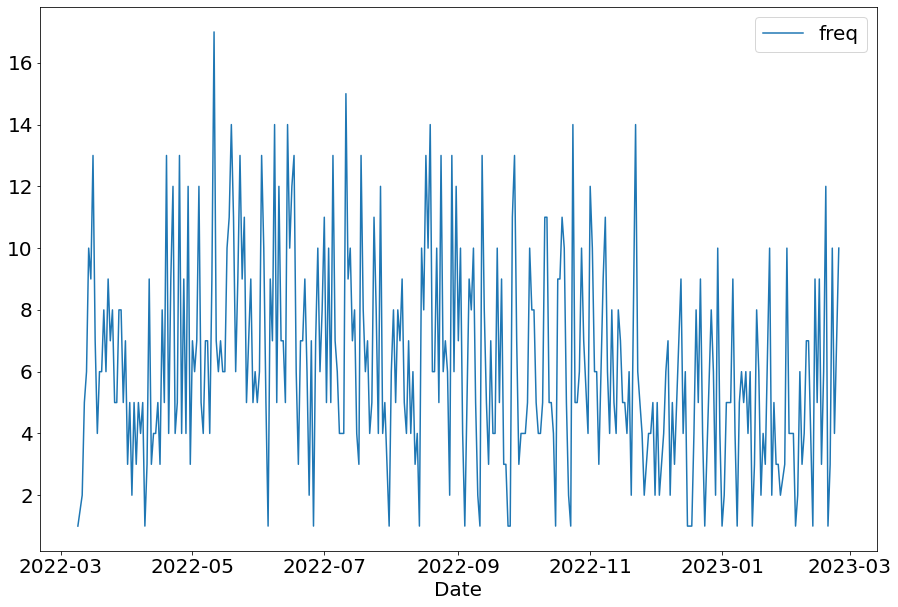

In [64]:
# plot Freq of messages 
daily_count.plot(x="just_date", y="freq", xlabel="Date", figsize= (15, 10))

In [46]:
daily_count.freq.mean() 

6.276967930029154

NYT posted ~6 messages daily, on average since the last year.


In [51]:
# Almost all of the messages have associated media 
nytimes_df.media.isna().value_counts()

False    2147
True        6
Name: media, dtype: int64

In [57]:
# Lets see what media is shared 
import re
nytimes_df["media_type"] = nytimes_df.media.apply(lambda a: re.sub("MessageMedia", "", a["_"]) if pd.notnull(a) else a)

<AxesSubplot:xlabel='Media Type', ylabel='Prop of messages'>

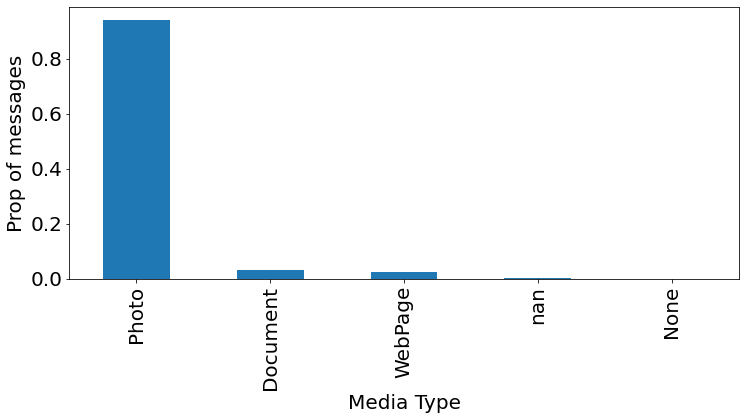

In [66]:
# Create a plot 
nytimes_df["media_type"].value_counts(normalize=True, dropna=False).plot(
    kind="bar", 
    ylabel="Prop of messages",
    xlabel = "Media Type",
    figsize=(12,5))




Almost all of the messages have associated media, mostly photos.

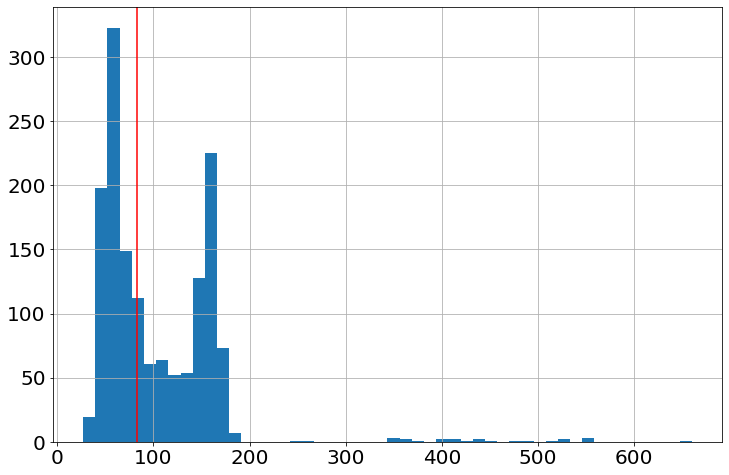

In [87]:
# How long are the messages?
num_words = nytimes_df.message.str.split().str.len()
num_words = num_words[num_words>0]

num_words.hist(bins=50, figsize=(12,8))
plt.axvline(x=num_words.median(), color="red")

# Most are upto 200 words long, with a median of ~80


In [107]:
# What are they posting about?
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
STOP = stopwords.words('english')

In [100]:
text = nytimes_df["message"].dropna()
text = text[text.str.len()>0]
text

3       Fear, Anger, Love: See Ukrainians’ Texts From ...
7       Our Photographers in Ukraine on the Images The...
8       The West Tried to Isolate Russia. It Didn’t Wo...
9       The U.N. General Assembly votes 141 to 7, with...
10      Prigozhin’s Feud With Russia’s Military Leaves...
                              ...                        
2146    Street battles hit a Kyiv suburb, some of the ...
2147    U.S. Officials Say Superyacht Could be Putin’s...
2148    After a night of shelling, Ukrainians assess t...
2150    The low rumble of heavy artillery fire echoed ...
2151    Welcome to the Telegram channel from The New Y...
Name: message, Length: 1490, dtype: object

In [109]:
# Get Tf-idf
vectorizer = TfidfVectorizer(stop_words=STOP) # remove stop words 
dtm=vectorizer.fit_transform(text)

In [110]:
vocab = vectorizer.get_feature_names()
# vectorizer.vocabulary_

In [111]:
# Top 30 words 
sum_words = dtm.sum(axis=0) # a 1x9211 matrix
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

words_freq[0:30]

[('ukraine', 70.99374965598217),
 ('russian', 60.91068005281544),
 ('russia', 60.3267722703442),
 ('ukrainian', 47.91682467181459),
 ('war', 41.971779410499686),
 ('said', 41.515413286769956),
 ('nytimes', 39.39641127730646),
 ('read', 39.12094018386512),
 ('city', 35.00237435757141),
 ('forces', 34.074497192425696),
 ('military', 31.931964324883396),
 ('putin', 31.503295287122306),
 ('president', 29.67814562804818),
 ('officials', 26.64096996670157),
 ('zelensky', 24.806368087293226),
 ('kyiv', 24.31848076238217),
 ('moscow', 24.088453872075334),
 ('country', 22.60569949567021),
 ('nuclear', 20.692177594132602),
 ('new', 20.13754759335653),
 ('eastern', 19.966650097196126),
 ('mr', 19.379073515804073),
 ('people', 19.21581532325555),
 ('one', 18.344061784065357),
 ('plant', 17.960637786763918),
 ('region', 17.87069827026016),
 ('invasion', 17.798213574656423),
 ('would', 17.681966632421336),
 ('kherson', 17.47786878804613),
 ('tuesday', 17.023810449552673)]

The top words are related to the war in Ukrain. This makes sense given that NYT started their Telegram channel in response to the Russian invasion and to specifically provide information to Ukrainians. 

In [131]:
# What are the different topics discussed?
from sklearn.cluster import KMeans
K = 10
kmeans_10 = KMeans(n_clusters=10)
kmeans_10.fit(dtm)


KMeans(n_clusters=10)

In [132]:
order_centroids = kmeans_10.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [135]:
for i in range(K):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),


Cluster 0:
 mariupol
 steel
 plant
 azovstal
 civilians
 city
 ukrainian
 said
 factory
 forces
Cluster 1:
 strikes
 missiles
 ukraine
 russian
 ukrainian
 least
 missile
 russia
 people
 air
Cluster 2:
 european
 nato
 ukraine
 germany
 russia
 gas
 oil
 leaders
 europe
 tanks
Cluster 3:
 nuclear
 plant
 zaporizhzhia
 power
 watchdog
 shelling
 ukraine
 agency
 ukrainian
 facility
Cluster 4:
 kherson
 city
 forces
 russian
 southern
 ukrainian
 region
 military
 ukraine
 russia
Cluster 5:
 russia
 ukraine
 war
 putin
 russian
 nytimes
 read
 said
 ukrainian
 military
Cluster 6:
 griner
 brittney
 star
 basketball
 drug
 court
 charges
 american
 lawyers
 trial
Cluster 7:
 grain
 deal
 food
 global
 ports
 odesa
 crisis
 ukraine
 sea
 black
Cluster 8:
 forces
 city
 ukrainian
 russian
 eastern
 ukraine
 russia
 region
 military
 donbas
Cluster 9:
 zelensky
 ukraine
 president
 volodymyr
 biden
 mr
 russia
 said
 war
 russian


We see topics related to attacks, specific incidents (e.g. cluster 0, 1, 4), likely topics about the international responses (cluster 2),  topic about Brittney Griner (cluster 6), topic about Zelensky (cluster 9)